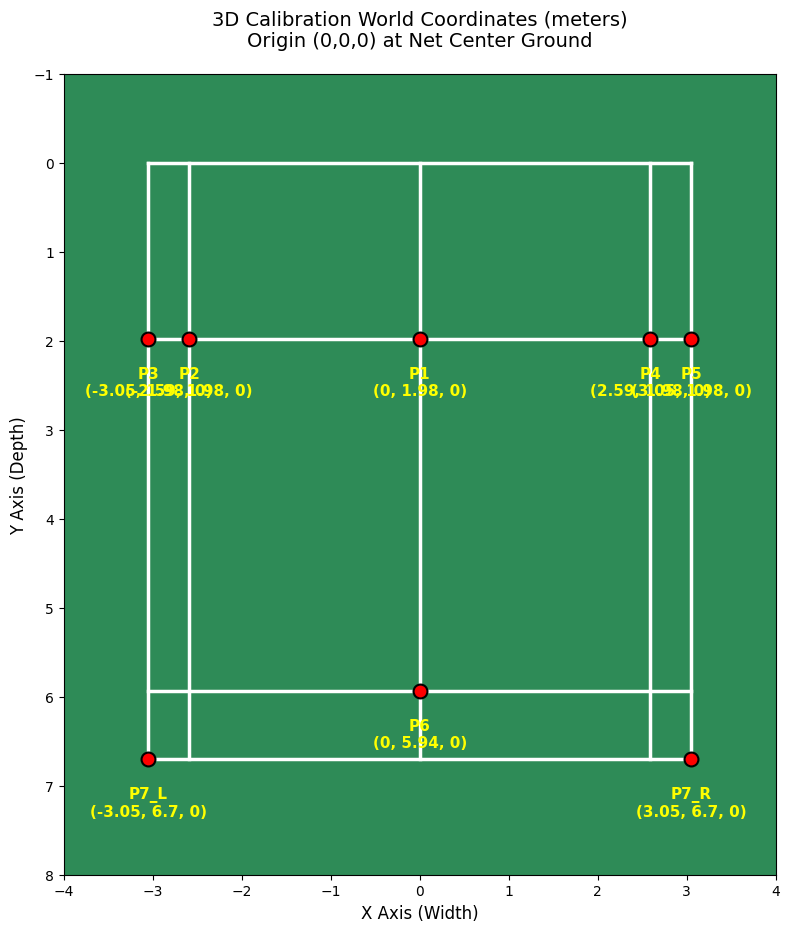

In [1]:
import matplotlib.pyplot as plt

def generate_court_map():
    # 設定畫布大小與顏色
    fig, ax = plt.subplots(figsize=(8, 10))
    ax.set_facecolor('#2E8B57') # 羽球場綠 (SeaGreen)

    # === 定義畫線函式 ===
    def plot_line(x_start, x_end, y_start, y_end):
        ax.plot([x_start, x_end], [y_start, y_end], color='white', linewidth=2.5)

    # === 1. 繪製標準半場線條 (世界座標系, 單位:公尺) ===
    # 橫線 (Horizontal)
    plot_line(-3.05, 3.05, 0, 0)       # 網子下投影線 (Y=0)
    plot_line(-3.05, 3.05, 1.98, 1.98) # 前發球線
    plot_line(-3.05, 3.05, 5.94, 5.94) # 後雙打發球線
    plot_line(-3.05, 3.05, 6.70, 6.70) # 底線

    # 直線 (Vertical)
    plot_line(0, 0, 0, 6.70)           # 中線
    plot_line(-2.59, -2.59, 0, 6.70)   # 左單打線
    plot_line(2.59, 2.59, 0, 6.70)     # 右單打線
    plot_line(-3.05, -3.05, 0, 6.70)   # 左邊線
    plot_line(3.05, 3.05, 0, 6.70)     # 右邊線

    # === 2. 標註關鍵點 (PnP Calibration Points) ===
    # 格式: (X, Y, Label)
    points = [
        (0, 1.98, "P1\n(0, 1.98, 0)"),
        (-2.59, 1.98, "P2\n(-2.59, 1.98, 0)"),
        (-3.05, 1.98, "P3\n(-3.05, 1.98, 0)"),
        (2.59, 1.98, "P4\n(2.59, 1.98, 0)"),
        (3.05, 1.98, "P5\n(3.05, 1.98, 0)"),
        (0, 5.94, "P6\n(0, 5.94, 0)"),
        (-3.05, 6.70, "P7_L\n(-3.05, 6.7, 0)"),
        (3.05, 6.70, "P7_R\n(3.05, 6.7, 0)")
    ]

    for x, y, label in points:
        ax.plot(x, y, 'ro', markersize=10, markeredgecolor='black', markeredgewidth=1.5)
        # 文字標籤稍微偏移以免擋住點
        ax.text(x, y + 0.3, label, ha='center', va='top', color='yellow', fontsize=11, fontweight='bold')

    # === 3. 圖表設定 ===
    ax.set_xlim(-4, 4)
    ax.set_ylim(8, -1) # Y軸反轉，讓0(網子)在上方
    ax.set_aspect('equal')
    ax.set_title("3D Calibration World Coordinates (meters)\nOrigin (0,0,0) at Net Center Ground", fontsize=14, pad=20)
    ax.set_xlabel("X Axis (Width)", fontsize=12)
    ax.set_ylabel("Y Axis (Depth)", fontsize=12)
    ax.grid(False)

    plt.tight_layout()
    plt.show()

# 執行函式
generate_court_map()


In [3]:
import cv2
import numpy as np

# ========== 設定參數區 (User Configuration) ==========
# 請填入您相機校正後獲得的「新相機矩陣 (New Camera Matrix)」
# 格式範例: np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
# 如果您是直接用 undistort 的圖片，Distortion Coeffs 設為 0
camera_matrix = np.array([[1405.99, 0, 928.57], [0, 1399.88, 646.73], [0, 0, 1]], dtype=np.float32) # 範例值，請替換成您算出來的真實值
dist_coeffs = np.zeros((4, 1))

# 載入您的圖片
img_path = './20251125_exp1_校正後圖片/int/left_img_undistorted.jpg' # 請改成您的檔名（路徑或檔名有中文沒問題）

# ==== 兼容 OpenCV 讀中文路徑圖片 ====
def imread_unicode(file_path):
    ''' 讀取包含中文路徑的圖片，回傳 BGR np.ndarray  '''
    # 用 numpy 讀二進位，再用OpenCV解
    img_array = np.fromfile(file_path, dtype=np.uint8)
    img = cv2.imdecode(img_array, cv2.IMREAD_COLOR)
    return img

def imwrite_unicode(file_path, img):
    ''' 儲存圖片到包含中文路徑 '''
    ext = '.' + file_path.split('.')[-1]
    result, n = cv2.imencode(ext, img)
    if result:
        n.tofile(file_path)
# ===================================

# 定義世界座標 (根據上面建議的座標系)
# 這裡預設順序為：
# 1. 中線與前發球線交點
# 2. 左雙打邊線與前發球線交點
# 3. 右雙打邊線與前發球線交點
# 4. 中線與後雙打發球線交點 (若看不清可改其他點)
object_points = np.array([
    [0, 1.98, 0],          # P1
    [-3.05, 1.98, 0],      # P3
    [3.05, 1.98, 0],       # P5
    [0, 5.94, 0]           # P6
], dtype=np.float32)

image_points = []

def click_event(event, x, y, flags, params):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f"Clicked Point: ({x}, {y})")
        image_points.append([x, y])
        # 畫個圈標記
        cv2.circle(img, (x, y), 5, (0, 0, 255), -1)
        cv2.imshow('Select Points', img)

img = imread_unicode(img_path)
if img is None:
    raise FileNotFoundError(f"找不到圖片：{img_path}。請確認路徑&檔名是否正確且有中文字可正常存取。")

print("請依序點擊以下 4 個點：")
print("1. 中線與前發球線交點 (T字)")
print("2. 左雙打邊線與前發球線交點")
print("3. 右雙打邊線與前發球線交點")
print("4. 中線與後雙打發球線交點")

cv2.imshow('Select Points', img)
cv2.setMouseCallback('Select Points', click_event)
cv2.waitKey(0)
cv2.destroyAllWindows()

if len(image_points) >= 4:
    image_points = np.array(image_points, dtype=np.float32)
    
    # 核心：Solve PnP
    success, rvec, tvec = cv2.solvePnP(object_points, image_points, camera_matrix, dist_coeffs)
    
    if success:
        print("-" * 30)
        print("PnP 解算成功！")
        print("旋轉向量 (rvec):\n", rvec)
        print("位移向量 (tvec):\n", tvec)
        print("-" * 30)
        
        # 驗證：將世界座標反投影回圖片，看是否重合
        projected_points, _ = cv2.projectPoints(object_points, rvec, tvec, camera_matrix, dist_coeffs)
        for p in projected_points:
            cv2.circle(img, (int(p[0][0]), int(p[0][1])), 8, (0, 255, 0), 2)
        
        # 顯示驗證結果 (綠色圈圈應該包住紅色點點)
        cv2.imshow('Projection Verification', img)
        cv2.waitKey(0)

        # 若要儲存結果（假如中文路徑下也能存）
        # imwrite_unicode('驗證_標記投影點.jpg', img)
        
        # 額外價值：計算相機高度
        # Tvec 的單位通常跟 World Coordinate 一樣 (公尺)
        # 理論上 Tvec 的 Y 或 Z 分量應該接近相機架設高度
        print(f"推估相機位置 (Camera Position in World): \n{-np.matrix(cv2.Rodrigues(rvec)[0]).T * np.matrix(tvec)}")
        
    else:
        print("PnP 解算失敗，請檢查點擊順序或座標設定。")
else:
    print("點擊點數不足 4 點。")

請依序點擊以下 4 個點：
1. 中線與前發球線交點 (T字)
2. 左雙打邊線與前發球線交點
3. 右雙打邊線與前發球線交點
4. 中線與後雙打發球線交點
Clicked Point: (1262, 742)
Clicked Point: (332, 1018)
Clicked Point: (1632, 620)
Clicked Point: (804, 417)
------------------------------
PnP 解算成功！
旋轉向量 (rvec):
 [[ 2.01712088]
 [-0.51684355]
 [ 0.45791044]]
位移向量 (tvec):
 [[2.14010167]
 [1.28827195]
 [3.77645165]]
------------------------------
推估相機位置 (Camera Position in World): 
[[-3.52849186]
 [-1.01265387]
 [ 2.6505743 ]]


In [6]:
import cv2

# 匯入圖片
image_path = input("請輸入圖片路徑：")
img = cv2.imread(image_path)
if img is None:
    print("讀取圖片失敗！請確認路徑正確。")
else:
    clicked_points = []

    def mouse_callback(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            cv2.circle(img, (x, y), 5, (0, 0, 255), -1)
            clicked_points.append((x, y))
            print(f"點擊座標：({x}, {y})")
            cv2.imshow("Image", img)

    print("請用滑鼠左鍵點擊目標位置，按下任意鍵結束。")
    cv2.imshow("Image", img)
    cv2.setMouseCallback("Image", mouse_callback)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    print("所有點擊的像素座標：")
    for idx, pt in enumerate(clicked_points, 1):
        print(f"{idx}: {pt}")


請用滑鼠左鍵點擊目標位置，按下任意鍵結束。
點擊座標：(996, 721)
點擊座標：(945, 545)
點擊座標：(942, 531)
所有點擊的像素座標：
1: (996, 721)
2: (945, 545)
3: (942, 531)
